Use this notebook to interactively apply style transfer onto a set of images.

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as util

from torch.utils.data import DataLoader

import copy
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Define Paths to Images

In [3]:
# location of style image
STYLE_IMAGE = "images/style_images/sample_vangogh.jpg"

# location of directory of content images
CONTENT_IMAGE_DIR = "./images/sample_content_images"

# (optional) Choose specific images in CONTENT_IMAGE_DIR. Will use ALL images in the CONTENT_IMAGE_DIR if None.
CONTENT_IMAGE_LIST = ["sample_0.jpg", "sample_1.jpg"]

# location of output directory (make sure this directory exists, create it if it doesn't)
OUTPUT_DIR = "./images/sample_output_images"

In [4]:
assert os.path.exists(STYLE_IMAGE)
assert os.path.exists(CONTENT_IMAGE_DIR)
assert os.path.exists(OUTPUT_DIR)
assert os.path.isdir(CONTENT_IMAGE_DIR)
assert os.path.isdir(OUTPUT_DIR)
for image_file in CONTENT_IMAGE_LIST:
    assert os.path.exists(os.path.join(CONTENT_IMAGE_DIR, image_file))

## Define Variables to Tune

In [5]:
# Content & Style weights
STYLE_WEIGHT = 10**8
CONTENT_WEIGHT = 10**0

# steps to create image
NUM_STEPS = 300

## Define content dataset 

In [6]:
class ContentDataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, files=None, transform=None):
        '''
        Args:
          root_dir (string): dir with all the images
          files ([string], optional): array of all the images to use in root_dir
            if not specified, use all images in root_dir
          transform (callable, optional): Optional transform to be
            applied on a sample
        '''
        self.root_dir = root_dir

        self.files = [f for f in (os.listdir(root_dir) if files is None else files) \
                      if os.path.isfile(os.path.join(root_dir, f))]

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        img = Image.open(os.path.join(self.root_dir, img_name))

        if self.transform:
            img = self.transform(img)

        return img, img_name


## Define classes for Style transfer

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = self._gram_matrix(target_feature).detach()

    def forward(self, input):
        G = self._gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    
    def _gram_matrix(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

    
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
    
# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

## Define Helper Functions

In [8]:
# desired depth layers to compute style/content losses:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=['conv_4'],
                               style_layers=['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, tmp_dir=False):
    
    """
    Run the style transfer.
    This function takes a tmp_dir parameter. If this parameter is specified,
        then intermediate results (at every 50 steps) will be saved to the 
        location specified in the parameter. If the parameter is set to
        False, then no intermediate results will be saved to disk.
    """
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)
    
    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print('run #{} - Style Loss : {:4f} Content Loss: {:4f}'.format(
                    run, style_score.item(), content_score.item()))
                
                # save tmp folder
                if tmp_dir:
                    if not os.path.exists(tmp_dir):
                        os.makedirs(tmp_dir)
                    util.save_image(input_img, '{0}/tmp_{1:0>4}.jpg'.format(tmp_dir, run[0]))

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

## Main Process: Load content/style images & apply style transfer

Setup image transformations

In [9]:
imsize = 360 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.CenterCrop(imsize), # crop on center
    transforms.ToTensor()])  # transform it into a torch tensor

Setup content image loader

In [10]:
content_img_set = ContentDataset(root_dir=CONTENT_IMAGE_DIR, files=CONTENT_IMAGE_LIST, transform=loader)
content_img_loader = DataLoader(content_img_set, batch_size=1, shuffle=False, num_workers=1)

Load style image

In [11]:
style_img = loader(Image.open(STYLE_IMAGE)).unsqueeze(0).to(device, torch.float)

Run style transfer

In [12]:
# use vgg19
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG networks are trained on images with each channel 
# normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# store image outputs in memory
output_imgs = []
content_imgs = []

for content_img_batch, content_filename_batch in content_img_loader:
    
    # load image and add image to content image array
    content_img = content_img_batch[0].unsqueeze(0).to(device, torch.float)
    content_filename = content_filename_batch[0]
    content_imgs.append(content_img)
    
    # use white noise image as input image:
    # input_img = torch.randn(content_img.data.size(), device=device)
    # use content image as input image:
    input_img = content_img.clone()

    # style transfer!
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_img, style_img, input_img, num_steps=NUM_STEPS,
                                style_weight=STYLE_WEIGHT, content_weight=CONTENT_WEIGHT,
                                tmp_dir='tmp')
    
    # add output image to array
    output_imgs.append(output)

    # save output image
    util.save_image(output, os.path.join(OUTPUT_DIR, '{0}.jpg'.format(content_filename.split('.')[0])))

Building the style transfer model..
Optimizing..
run #[50] - Style Loss : 31519.343750 Content Loss: 34.511822
run #[100] - Style Loss : 2243.663330 Content Loss: 36.235264
run #[150] - Style Loss : 900.911499 Content Loss: 37.607826
run #[200] - Style Loss : 399.009888 Content Loss: 37.865738
Building the style transfer model..
Optimizing..
run #[50] - Style Loss : 8454.083984 Content Loss: 25.268789
run #[100] - Style Loss : 2398.548096 Content Loss: 28.514277
run #[150] - Style Loss : 1128.687500 Content Loss: 30.626011
run #[200] - Style Loss : 551.857849 Content Loss: 31.994865


## View the images! (Used to test and tune style transfer paremeters)

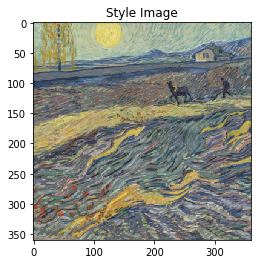

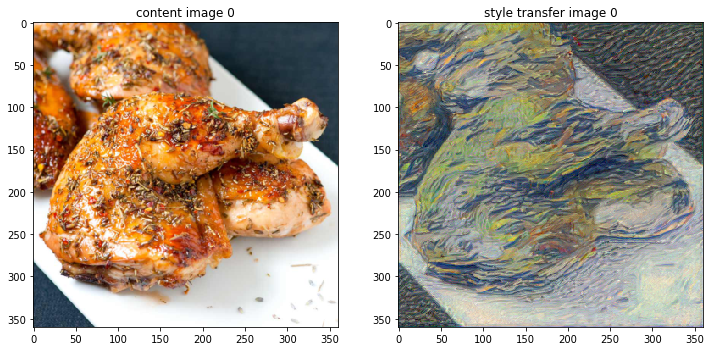

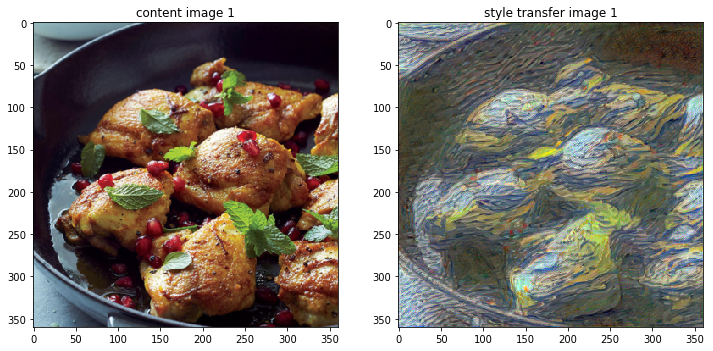

In [13]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion() # interactive on

def imshow(tensor, title="", ax=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.title(title)
    if ax:
        ax.imshow(image)
    else:
        plt.imshow(image)
        plt.pause(0.001) # pause a bit so that plots are updated

# plot style
plt.figure()
imshow(style_img, title='Style Image')

# plot content & output images
for i, (c, o) in enumerate(zip(content_imgs, output_imgs)):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(121)
    imshow(c, title='content image {}'.format(i), ax=ax1)
    ax2 = fig.add_subplot(122)
    imshow(o, title='style transfer image {}'.format(i), ax=ax2)
